# Classify the flowers shown in the flower dataset

* The flowers are in color and you'll have to work with that. You can't turn them to greyscale etc.
* Data augmentation is allowed here due to popular complaint, but the problem can be completed without it




In [1]:
# Importing the libraries
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets,models, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# !pip install torchsummary 
# from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark=True

# Loading the Training and Testing Data using Data Loader with Data Augmentation



In [2]:
# Loading the Training and Testing Data
trainImages = np.load('./Flowers/flower_imgs.npy')
trainLabels = np.load('./Flowers/flower_labels.npy')
# Splitting the Data into Training and Test Data
X_train, X_test,Y_train,Y_test = train_test_split(trainImages,trainLabels, test_size=0.15, shuffle = True)

# Finding the mean and the Variance
img_mean = np.mean(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
img_std = np.std(np.swapaxes(trainImages/255.0,0,1).reshape(3, -1), 1)
print("mean: {}, std: {}".format(img_mean, img_std))


mean: [0.43430043 0.43250865 0.35484957], std: [0.28290703 0.26667351 0.25423616]


In [3]:
class FlowerLoader(torch.utils.data.Dataset):
    def __init__(self, x_arr, y_arr, transform=None):
        self.x_arr = x_arr
        self.y_arr = y_arr
        self.transform = transform

    def __len__(self):
        return self.x_arr.shape[0]

    def __getitem__(self, index):
        img = self.x_arr[index]
        label = self.y_arr[index]
        if self.transform is not None:
            img = self.transform(img)

        return img, label

## Normalizing about mean and variance
* Also defining Train and Test Data Loaders
* Train Data Loader has shuffle = True; This will ensure that every epoch the data in each minibatch will be shuffled, which ideal to prevent overfitting.
* MiniBatch of 64 is chosen, as Testing accuracy ranges around 74 -78 percent with other sizes like 128 or 256.
* Data Augmentation is enabled for train loader again to decrease overfitting.
* For Test Loader only the normalized parameter is used. This is to ensure that we get the right accuracy. 

In [4]:
## Normalizing the Data
normalize = transforms.Normalize(mean=list(img_mean),std=list(img_std))
batch_size =64

train_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_train, Y_train, transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=True)
# remove augmentation transforms in test loader
test_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_test, Y_test, transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize,
    ])), 
      batch_size=batch_size,shuffle=False)

# Showing the Input Data 
* Dint use Pytorch to show data as, I already had code written using numpy

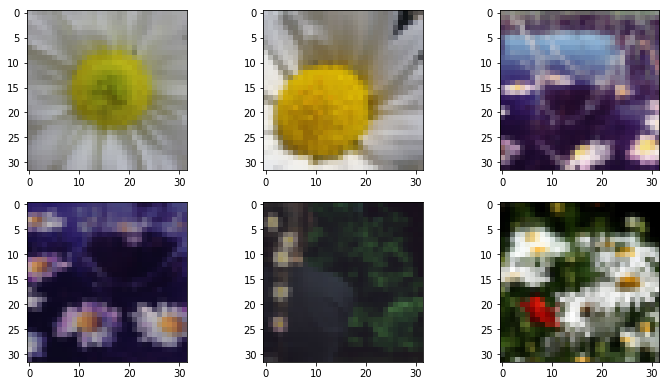

In [5]:
# Preview the training data
plt.figure(figsize=(12,10))# Showing the Input Data after Normalizing
x, y = 3, 3
for i in range(6):  
    plt.subplot(y, x, i+1)
    plt.imshow(trainImages[i],interpolation='nearest')
plt.show()

## Defining Convolution Neural Network
* Initially I tried using 2 and 3 layer convolutions with dropout(0.5) and batchregularization, but the accuracy varied between 69 - (75, 77 ) percent. After taking suggestions from comments on Piazza, I tried implementing VGG.
* After Implementing different VGG Networks, VGG13 gave the best results. 
* I modified the original network to increase accuracy from 80 to 83 percent. This was due to changing the activation function and using dropouts.


In [6]:
# Code Modified from  https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
config = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512 ,512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128,'D', 128, 'M', 256,'D', 256, 256, 256, 'M', 512,'D', 512, 512, 512, 'M', 512,'D', 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.conv = self._make_layers(config[vgg_name])
        self.linear = self._make_layers_linear()

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def vis(self, x):
        out = self.conv(x)
        return out
    
    def swish(self,x):
        return x * torch.sigmoid(x) # Tried using this, but as the error did not converge, not used later on.

    def _make_layers(self, config):
        layers = []
        in_channels = 3
        for x in config:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] 
            elif x == 'D':
                layers+= [nn.Dropout(0.5)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # Padding is adjusted 
                                                                               # To presever spatial dimension. 
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]#inplace=True, PReLU()
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    def _make_layers_linear(self):
        layers = []
#         layers +=[nn.Linear(512, 256)]
#         layers+= [nn.Dropout(0.5)]
        layers += [nn.Linear(512, 5)]
#         layers += [nn.LogSoftmax()]
#         layers += [nn.Linear(64, 5)]
        return nn.Sequential(*layers) # Try softmax here

net = VGG('VGG13')
net.to(device)

VGG(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), st

In [7]:
# If want to get a summary of the network uncomment the below line as well as the one in importing libraries.
# summary(net,(3,32,32),batch_size=batch_size)

##  Define a Loss function and optimizer
* Cross Entropy Loss is used as there are multiiple classes (5). 
* Different Permuation of the learning rate and optimizers were tried. The table I created for getting intition for accuracy and error can be found below or attached with homework sumission.
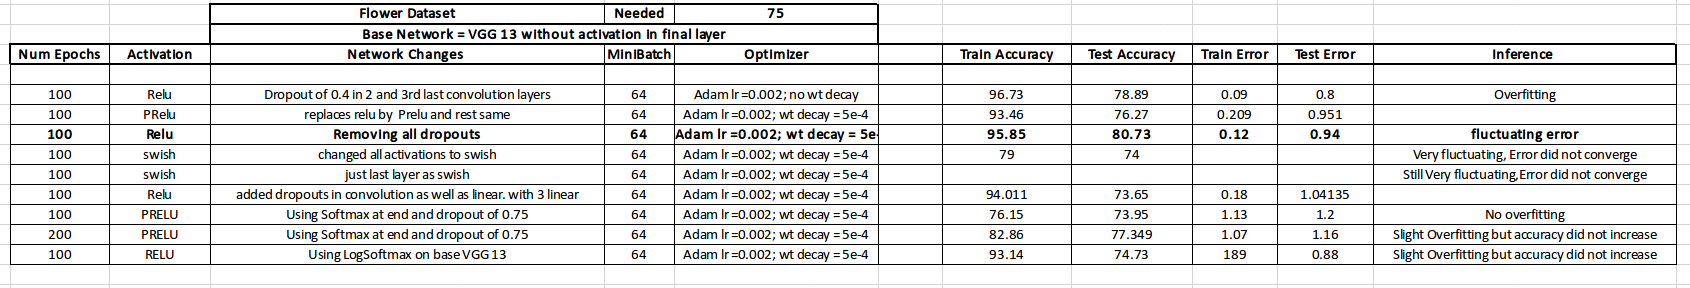
* After all the experimentation, the original vgg 13 network worked the best. Adding dropouts did not help, I guess this is due to not adding them at the right position. I also tried increasing the fully connected layers but it did not help.
* The most significant discrepancy was found that, when not using softmax layer or log softmax layer, the testing accuracy actually came out to be more. I dont know why this happened!!! 

In [8]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() 
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay = 5e-4)
optimizer = optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay= 5e-4)
train_loss =[]
val_loss = []
train_accu = []
test_accu=[]

In [9]:
# For Debugging
# for batch_idx, (data, target) in enumerate(train_loader):
#     data, target = data.to(device), target.to(device)
#     output = net(data)
# # #         print(target.dtype,output.dtype)
#     loss = criterion(output, target)
#     # loss.backward()
#     # optimizer.step()
#     break
# target

## Training and Testing Functions

In [10]:
def train(model, train_loader, optimizer, epoch,device):
#     print(criterion)
    training_loss = 0
    train_correct = 0
    lo = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        #==== Forward Pass=====
        output = model(data)
        loss = criterion(output, target)
        #=====Backward Pass=======
        loss.backward()
        optimizer.step()
        #=== Loss Append to get loss of entire Batch====
        lo.append(loss.item())
        #==== Calculating Training Accuracy========= 
        train_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += train_pred.eq(target.view_as(train_pred)).sum().item()
        #======= Logging results after every 20th batch============ 
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    #======== Getting Accuracy of the entire epoch by averaging of each batch===========    
    train_accu.append(100. * train_correct / len(train_loader.dataset))
    #======== Getting Training Loss of the epoch by averaging across each batch
    train_loss.append(np.mean(lo))

def test(model, test_loader,device):
    test_loss = 0
    correct = 0
    testlo = []
    with torch.no_grad(): # as we dont need to backpropogate when calculating testing error and accuracy
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #==== Getting the Prediction======
            output = model(data)
            #===== Calculating the Loss=========
            test_loss = criterion(output, target)
            testlo.append(test_loss.item())
            # Calculating Testing Accuracy for the all inputs=========
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    #======= Getting Testing Accuracy for the Epoch========
    test_accu.append(100. * correct / len(test_loader.dataset))
    #====== Getting Testing Error of Epoch========
    val_loss.append(np.mean(testlo))
   #======= Logging results after every epoch ============ 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        np.mean(testlo), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
device

device(type='cuda', index=0)

# Training the Model

In [12]:
epochs = 100
for epoch in range(1, epochs + 1):
        train(net, train_loader, optimizer, epoch,device)
        test(net, test_loader,device)

Train Epoch: 1 [0/3674 (0%)]	Loss: 1.608994
Train Epoch: 1 [1280/3674 (34%)]	Loss: 1.410705
Train Epoch: 1 [2560/3674 (69%)]	Loss: 1.310299

Test set: Average loss: 1.2526, Accuracy: 295/649 (45%)

Train Epoch: 2 [0/3674 (0%)]	Loss: 1.209350
Train Epoch: 2 [1280/3674 (34%)]	Loss: 1.399297
Train Epoch: 2 [2560/3674 (69%)]	Loss: 1.039957

Test set: Average loss: 1.1428, Accuracy: 406/649 (63%)

Train Epoch: 3 [0/3674 (0%)]	Loss: 1.257898
Train Epoch: 3 [1280/3674 (34%)]	Loss: 0.817795
Train Epoch: 3 [2560/3674 (69%)]	Loss: 1.137731

Test set: Average loss: 1.1114, Accuracy: 361/649 (56%)

Train Epoch: 4 [0/3674 (0%)]	Loss: 0.873517
Train Epoch: 4 [1280/3674 (34%)]	Loss: 1.072642
Train Epoch: 4 [2560/3674 (69%)]	Loss: 1.003441

Test set: Average loss: 1.0270, Accuracy: 426/649 (66%)

Train Epoch: 5 [0/3674 (0%)]	Loss: 0.924251
Train Epoch: 5 [1280/3674 (34%)]	Loss: 0.973381
Train Epoch: 5 [2560/3674 (69%)]	Loss: 1.174319

Test set: Average loss: 1.0781, Accuracy: 422/649 (65%)

Train Epoc

Train Epoch: 42 [1280/3674 (34%)]	Loss: 0.702472
Train Epoch: 42 [2560/3674 (69%)]	Loss: 0.543899

Test set: Average loss: 0.7833, Accuracy: 502/649 (77%)

Train Epoch: 43 [0/3674 (0%)]	Loss: 0.309667
Train Epoch: 43 [1280/3674 (34%)]	Loss: 0.591447
Train Epoch: 43 [2560/3674 (69%)]	Loss: 0.425556

Test set: Average loss: 0.8747, Accuracy: 483/649 (74%)

Train Epoch: 44 [0/3674 (0%)]	Loss: 0.303579
Train Epoch: 44 [1280/3674 (34%)]	Loss: 0.434516
Train Epoch: 44 [2560/3674 (69%)]	Loss: 0.537983

Test set: Average loss: 0.7413, Accuracy: 510/649 (79%)

Train Epoch: 45 [0/3674 (0%)]	Loss: 0.389380
Train Epoch: 45 [1280/3674 (34%)]	Loss: 0.359473
Train Epoch: 45 [2560/3674 (69%)]	Loss: 0.462237

Test set: Average loss: 0.8582, Accuracy: 501/649 (77%)

Train Epoch: 46 [0/3674 (0%)]	Loss: 0.400544
Train Epoch: 46 [1280/3674 (34%)]	Loss: 0.386269
Train Epoch: 46 [2560/3674 (69%)]	Loss: 0.470196

Test set: Average loss: 0.7847, Accuracy: 506/649 (78%)

Train Epoch: 47 [0/3674 (0%)]	Loss: 0.50

Train Epoch: 83 [1280/3674 (34%)]	Loss: 0.372922
Train Epoch: 83 [2560/3674 (69%)]	Loss: 0.271374

Test set: Average loss: 0.7897, Accuracy: 515/649 (79%)

Train Epoch: 84 [0/3674 (0%)]	Loss: 0.184057
Train Epoch: 84 [1280/3674 (34%)]	Loss: 0.456807
Train Epoch: 84 [2560/3674 (69%)]	Loss: 0.483051

Test set: Average loss: 0.9597, Accuracy: 498/649 (77%)

Train Epoch: 85 [0/3674 (0%)]	Loss: 0.278278
Train Epoch: 85 [1280/3674 (34%)]	Loss: 0.181645
Train Epoch: 85 [2560/3674 (69%)]	Loss: 0.294773

Test set: Average loss: 0.8643, Accuracy: 506/649 (78%)

Train Epoch: 86 [0/3674 (0%)]	Loss: 0.153249
Train Epoch: 86 [1280/3674 (34%)]	Loss: 0.152917
Train Epoch: 86 [2560/3674 (69%)]	Loss: 0.203054

Test set: Average loss: 0.8773, Accuracy: 516/649 (80%)

Train Epoch: 87 [0/3674 (0%)]	Loss: 0.429712
Train Epoch: 87 [1280/3674 (34%)]	Loss: 0.123388
Train Epoch: 87 [2560/3674 (69%)]	Loss: 0.176095

Test set: Average loss: 0.9449, Accuracy: 505/649 (78%)

Train Epoch: 88 [0/3674 (0%)]	Loss: 0.14

Training Loss: 0.1940633829939982
Training Accuracy: 93.38595536200327

Test Loss: 0.8663266570595178
Testing Accuracy: 81.5100154083205



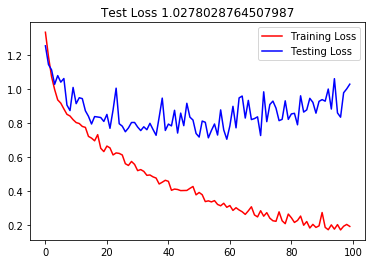

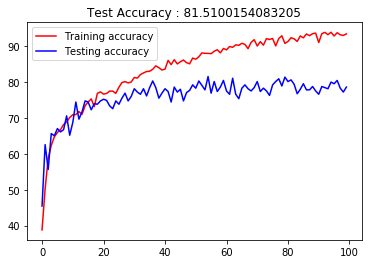

In [19]:
# Evaluate Accuracy
print('Training Loss:', train_loss[-1])
print('Training Accuracy:', train_accu[-1])
print()
print('Test Loss:', np.mean(val_loss))
print('Testing Accuracy:', np.max(test_accu))
print()

plt.plot(train_loss,'r', label='Training Loss')
plt.plot(val_loss,'b', label='Testing Loss')
plt.title('Test Loss ' + str(val_loss[-1]))
plt.legend()
plt.show()
plt.plot(train_accu,'r', label='Training accuracy')
plt.plot(test_accu,'b', label='Testing accuracy')
plt.title('Test Accuracy : '+ str(np.max(test_accu)))
plt.legend()
plt.show()

## Inferences
* It is clear from the abive graph that, there is overfitting in the network.
* I tried different menthods like changing dropouts and actiavtion functions to do address this.
* This did not help as, even though the overfitting decreased the final test accuracy always decreased.
* Adam gave beteer performance than SGD.
* The haphazard motion of both error and accuracy is due to the random shuffling of data in minibatches after each epoch.

# Incorrect Predictions


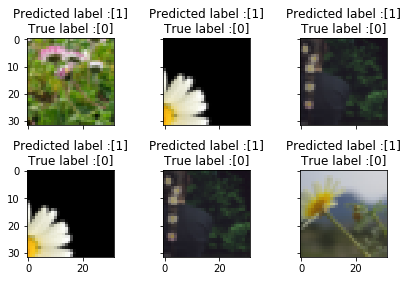

In [20]:
err=[]
ind=[]
predictedlabel=[]
targetlabel=[]
n = 6   # Number of False predictions to output


vis_loader = torch.utils.data.DataLoader(
    FlowerLoader(X_test, Y_test, transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        normalize,
    ])), shuffle=False)

for data, target in vis_loader:
    data, target = data.to(device), target.to(device)
    #==== Getting the Prediction======
    output = net(data)
    #===== Calculating the Loss=========
    test_loss = criterion(output, target)
    err.append(test_loss.item())
    # Checking what predictions are correct========
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    predictedlabel.append(pred.item())
    targetlabel.append(target.item())
    neg = ~pred.eq(target.view_as(pred))
    ind.append(neg.item())
    
    
ind,err,predictedlabel,targetlabel =np.asarray(ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]

#======= Plotting Incorrect=======
nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(X_test[maxerrorind[row+col]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(predictedlabel[[maxerrorind[row+col]]],
                                                                               targetlabel[[maxerrorind[row+col]]]))
fig.tight_layout()


## Correct Predictions

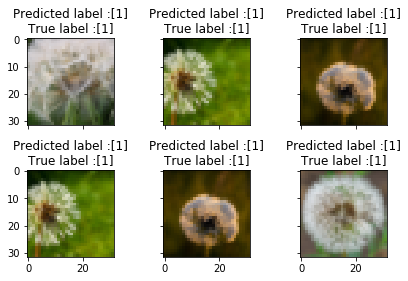

In [15]:
#======= Plotting Correct=======

ind,err,predictedlabel,targetlabel =np.asarray(~ind), np.asarray(err), np.asarray(predictedlabel),np.asarray(targetlabel)
incorrecterrors=ind*err
maxerrorind = np.argpartition(incorrecterrors, -n)[-n:]


nrows,ncols = 2 ,3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(X_test[maxerrorind[row+col]])
        ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(predictedlabel[[maxerrorind[row+col]]],
                                                                               targetlabel[[maxerrorind[row+col]]]))
fig.tight_layout()